# Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (in sklearn, obviously). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the next exercise, you will implement your own LASSO solver, using coordinate descent. 

## The usual

In [78]:
import sklearn
import pandas as pd
import numpy as np

## Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located. *I am so surprised.*

In [2]:
full_data = pd.read_csv("kc_house_data.csv", index_col=0)

## Create new features

As in Lab 2 (*lab-2.ipynb*), we consider features that are some transformations of inputs.

In [3]:
from math import log, sqrt
full_data['sqft_living_sqrt'] = full_data['sqft_living'].map(sqrt)
full_data['sqft_lot_sqrt'] = full_data['sqft_lot'].map(sqrt)
full_data['bedrooms_square'] = full_data['bedrooms'] ** 2

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
full_data['floors'] = full_data['floors'].astype(float) 
full_data['floors_square'] = full_data['floors'] ** 2

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [4]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`alpha=l1_penalty`) to the sklearn model `Lasso`. (Other tools may have separate implementations of LASSO). Much like L2/Ridge Regression, the features should be scaled to ensure equal attention inbetween.

In [5]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
l1_penalty=5e4
full_features = scaler.fit_transform(full_data[all_features].values)
full_labels = full_data['price'].values
model = Lasso(alpha=l1_penalty).fit(full_features, full_labels)

In [6]:
model

Lasso(alpha=50000.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Find what features had non-zero weight.

In [7]:
# Do you know that even numpy has built-in boolean selector?
np.array(all_features)[model.coef_ != 0]

array(['sqft_living', 'waterfront', 'view', 'grade', 'yr_built'],
      dtype='<U16')

In [8]:
model.intercept_

540088.1417665294

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [53]:
from sklearn.model_selection import train_test_split
# Cookie for those who instantly remember what cell to copy
train_validation_set, test_set = train_test_split(full_data, train_size=0.9, test_size=0.1, random_state=1)
train_set, validation_set = train_test_split(train_validation_set, train_size=0.5, test_size=0.5, random_state=1)

Next, we write a loop that does the following:
* For `l1_penalty` in 21 steps range between [1, 10^9] (use `np.logspace(0, 9, num=21)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `alpha=l1_penalty` in the parameter.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

In [54]:
# Handholding level: Nominally.
# get features and labels on training set
X_train_features = scaler.transform(train_set[all_features].values)
y_train_label = train_set['price'].values
# get features and labels on validation set
X_validation_features = scaler.transform(validation_set[all_features].values)
y_validation_label = validation_set['price'].values
return_data_list = []
for l1_penalty in np.logspace(0, 9, 21):
    model = Lasso(alpha=l1_penalty).fit(X_train_features, y_train_label)
    y_predict = model.predict(X_validation_features)
    rss = np.sum(np.square(y_validation_label - y_predict))
    return_data_list.append([rss, l1_penalty, model])

/home/leanh/anaconda3/envs/ml-301x/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14654475719675.5, tolerance: 127509489470.134
  positive)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


/home/leanh/anaconda3/envs/ml-301x/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14663181882952.375, tolerance: 127509489470.134
  positive)


Lasso(alpha=2.8183829312644537, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


/home/leanh/anaconda3/envs/ml-301x/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14687653596241.812, tolerance: 127509489470.134
  positive)


Lasso(alpha=7.943282347242816, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


/home/leanh/anaconda3/envs/ml-301x/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14755977786894.688, tolerance: 127509489470.134
  positive)


Lasso(alpha=22.3872113856834, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


/home/leanh/anaconda3/envs/ml-301x/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14943361906599.0, tolerance: 127509489470.134
  positive)


Lasso(alpha=63.09573444801933, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


/home/leanh/anaconda3/envs/ml-301x/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15430211624777.625, tolerance: 127509489470.134
  positive)


Lasso(alpha=177.82794100389228, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


/home/leanh/anaconda3/envs/ml-301x/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16474937844499.812, tolerance: 127509489470.134
  positive)


Lasso(alpha=501.18723362727246, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=1412.537544622754, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=3981.0717055349733, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=11220.18454301963, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=31622.776601683792, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None

*** QUIZ QUESTION. *** What was the best value for the `l1_penalty`?

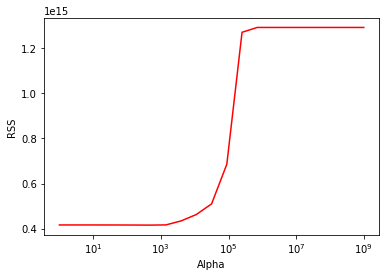

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
l = np.array(return_data_list)
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("RSS")
plt.plot(l[:, 1].tolist(), l[:, 0].tolist(), color='r')

In [56]:
# Eyeball power, or computation power?
sorted_data = sorted(return_data_list)
sorted_data[0][1]

501.18723362727246

***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [57]:
# Interesting, isn't it
best_model = sorted_data[0][2]
np.count_nonzero(best_model.coef_)

17

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 5 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [58]:
max_nonzeros = 5

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [59]:
l1_penalty_values = np.logspace(3, 5, num=21)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(3, 5, num=21)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `alpha=l1_penalty` in the parameter.
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model.coef_` gives you the coefficients/parameters you learned (barring intercept) in the form of numpy array. You can then use array\[condition\] for the list of values passing the condition. Or just use the builtin `np.count_nonzero()`

In [60]:
# Or you can do it with pure python. Its impact on the performance is negligible.
return_data = []
for l1_penalty in l1_penalty_values:
    model = Lasso(alpha=l1_penalty).fit(X_train_features, y_train_label)
#     y_predict = model.predict(X_validation_features)
#     rss = np.sum(np.square(y_validation_label - y_predict))
    num_nonzero = np.count_nonzero(model.coef_)
    return_data.append([l1_penalty, num_nonzero])

Lasso(alpha=1000.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=1258.9254117941675, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=1584.893192461114, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=1995.2623149688789, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=2511.88643150958, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selec

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The smallest `l1_penalty` that has non-zeros equal `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The biggest `l1_penalty` that has non-zeros equal `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [61]:
print(*return_data, sep='\n')

[15, 1000.0]
[15, 1258.9254117941675]
[15, 1584.893192461114]
[15, 1995.2623149688789]
[15, 2511.88643150958]
[14, 3162.2776601683795]
[13, 3981.0717055349733]
[13, 5011.872336272725]
[10, 6309.57344480193]
[10, 7943.282347242814]
[10, 10000.0]
[10, 12589.254117941662]
[6, 15848.93192461114]
[6, 19952.62314968879]
[5, 25118.864315095823]
[5, 31622.776601683792]
[5, 39810.71705534969]
[5, 50118.72336272725]
[4, 63095.7344480193]
[3, 79432.82347242821]
[2, 100000.0]


In [73]:
np_array = np.array(return_data)
l1_penalty_max = np_array[np.where(np_array[:, 0] == max_nonzeros), 1][0, -1]
l1_penalty_min = np_array[np.where(np_array[:, 0] == max_nonzeros), 1][0, 0]
print(l1_penalty_max, l1_penalty_min)

50118.72336272725 25118.864315095823



***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [74]:
l1_penalty_values_narrow = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `alpha=l1_penalty`.
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

In [75]:
data = []
for l1_penalty in l1_penalty_values_narrow: # for each l1 in list l1_penalty_values_narrow
    model = Lasso(alpha=l1_penalty).fit(X_train_features, y_train_label)
    y_predict = model.predict(X_validation_features)
    rss = np.sum(np.square(y_validation_label - y_predict))
    data.append([rss, l1_penalty, np.count_nonzero(model.coef_), model])

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [76]:
print('Answer question 1: {}\nAnswer question 2: {}'.
      format(sorted(data)[0][1], np.array(all_features)[sorted(data)[0][3].coef_ != 0]))

Answer question 1: 25118.864315095823
Answer question 2: ['sqft_living' 'waterfront' 'view' 'grade' 'yr_built']


In [77]:
np_data = np.array(sorted(data))
print(*np_data[:,0:3], sep='\n')

[493521711338201.5 25118.864315095823 5]
[496574575559483.1 26434.64637023432 5]
[499764416429739.25 27750.428425372815 5]
[503090906690931.75 29066.210480511312 5]
[506554043217954.94 30381.992535649806 5]
[510153827525216.94 31697.774590788304 5]
[513890260225477.94 33013.5566459268 5]
[517763341318737.7 34329.338701065295 5]
[521773070804996.1 35645.12075620379 5]
[525919448684253.5 36960.90281134229 5]
[530202474956509.6 38276.684866480784 5]
[534622149621764.5 39592.466921619285 5]
[539178473397453.6 40908.24897675778 5]
[543871449941393.25 42224.03103189627 5]
[548701075293986.5 43539.81308703477 5]
[553667349455233.5 44855.59514217326 5]
[558770272425134.4 46171.37719731176 5]
[564009844203689.0 47487.15925245026 5]
[569386064790897.4 48802.94130758876 5]
[574898934186759.2 50118.72336272725 5]
